# Image Classification
## VGG16 모델 구현하기
영상의 내용을 참고하여 직접 코드로 모델을 구현해 보세요. Batch Normalization, Parameter Initialization 등을 사용할 수도 있습니다.

### 1. 필요한 라이브러리 불러오기.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

### 2. 데이터를 준비
불러온 데이터는 캐글에서 제공되는 개와 고양이의 데이터로, 이번 프로젝트에서 우리는 개와 고양이를 분류할 예정입니다. 
test 데이터에서 1은 개, 0은 고양이를 의미합니다.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

### 2-1. train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장해 둡니다.

In [3]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


In [4]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


### 2-2. train 데이터와 validation 데이터의 개수를 알아봅시다.

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


### 3. 필요한 파라미터를 설정해 줍시다. 파라미터를 수정하면 성능을 높일 수 있으니 다양한 실험을 해보세요.

In [6]:
# parameter Initialization
batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

### 4. 이미지를 확인하기 위해 데이터를 시각화하는 함수를 만들기

In [7]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### 5. Train 데이터의 사이즈가 작아서, Data Augmentation(데이터 증각)을 통해 데이터의 수를 늘리기.
Data Augmentation은 Rescale, Rotation, Random Crop, Zoom, Flip 등 다양한 기법을 사용하여 데이터의 양을 증가시키는 것입니다. range의 숫자를 변화시키거나 Flip에서 True/False를 적절하게 사용하여 다양한 실험을 해보세요.

In [8]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)


### 5-1. .flow_from_directory를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결시켜기.
개와 고양이를 분류하는 task를 수행하기 때문에class_mode는 'binary'입니다. Classification task에 따라 class_mode를 변경하시면 됩니다.

In [9]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


### 5-2. Data Augmentation이 제대로 되었는지 확인

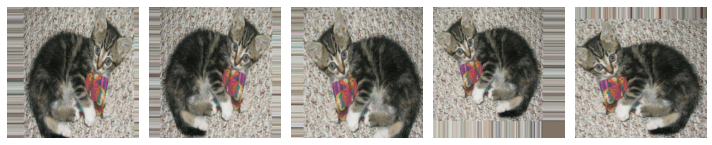

In [10]:
train_data_gen[0][0].shape
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 6. Validation 데이터에도 train 데이터와 같은 동일한 작업을 해주기.
 그러나 Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 데이터의 스케일만 변경해 줍니다.

In [11]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


### 6-1. Validation 데이터를 확인
크게 이미지와 정답 데이터로 구성이 되어 있습니다.

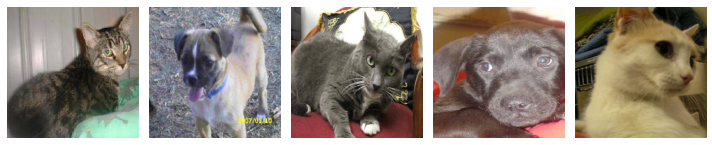

In [12]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [13]:
_[:5] # 정답 데이터

array([0., 1., 0., 1., 0.], dtype=float32)

# VGG16 모델 구현하기!
주어진 모델 구현 코드를 참고하여 모델을 직접 구현해보기.
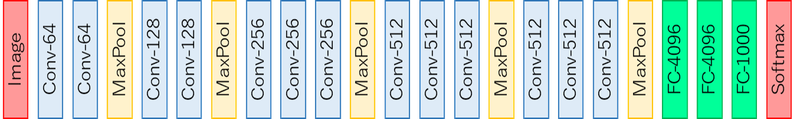

In [14]:
input_layer = tf.keras.layers.Input(shape=(256, 256, 3))
conv64_1 = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
conv64_2 = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(conv64_1)
batch_nml_1 = tf.keras.layers.BatchNormalization()(conv64_2)
maxpool_1 = tf.keras.layers.MaxPool2D((2, 2))(conv64_2)

conv128_1 = tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(maxpool_1)
conv128_2 = tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(conv128_1)
batch_nml_2 = tf.keras.layers.BatchNormalization()(conv128_2)
maxpool_2 = tf.keras.layers.MaxPool2D((2, 2))(conv128_2)

conv256_1 = tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(maxpool_2)
conv256_2 = tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(conv256_1)
conv256_3 = tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(conv256_2)
batch_nml_3 = tf.keras.layers.BatchNormalization()(conv256_3)
maxpool_3 = tf.keras.layers.MaxPool2D((2, 2))(conv256_3)

conv512_1 = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(maxpool_3)
conv512_2 = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv512_1)
conv512_3 = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv512_2)
batch_nml_4 = tf.keras.layers.BatchNormalization()(conv512_3)
maxpool_4 = tf.keras.layers.MaxPool2D((2, 2))(conv512_3)

conv512_4 = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(maxpool_4)
conv512_5 = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv512_4)
conv512_6 = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv512_5)
batch_nml_5 = tf.keras.layers.BatchNormalization()(conv512_6)
maxpool_5 = tf.keras.layers.MaxPool2D((2, 2))(conv512_6)

flatten_layer = tf.keras.layers.Flatten()(maxpool_5)
fc_1 = tf.keras.layers.Dense(4096, activation='relu')(flatten_layer)
fc_2 = tf.keras.layers.Dense(4096, activation='relu')(fc_1)
fc_3 = tf.keras.layers.Dense(1000, activation='relu')(fc_2)
output_layer = tf.keras.layers.Dense(1, activation='softmax')(fc_3)

model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0     

## 손실함수, optimizer, metric을 설정하기
손실함수와 metric은 분류 task에 따라 다양하게 바꿀 수 있습니다. optimizer도 Adam 외에 다양한 것을 사용할 수 있습니다.

In [15]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

# 모델 학습 시키기
data generator는 입력 데이터와 타겟(라벨)의 batch를 끝없이 반환합니다.
batch가 끝없이 생성되기 때문에, 한 번의 epoch에 generator로부터 얼마나 많은 샘플을 뽑을지 모델에 전달해야 합니다.
- 만약 batch_size=20이고 steps_per_epoch=100일 경우 (데이터, 라벨)의 쌍 20개가 생성되고, 크기가 20인 batch 데이터를 100번 학습하면 1 epoch이 완료됩니다. 
- 단, 크기 20의 batch 데이터는 매번 랜덤으로 생성됩니다.
*일반적으로 (전체 데이터 길이/batch_size)를 steps_per_epoch으로 설정합니다.

In [16]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5
125/125 [==============================] - 61s 421ms/step - loss: 31784502.0000 - binary_accuracy: 0.5000 - val_loss: 0.6939 - val_binary_accuracy: 0.5000
Epoch 2/5
125/125 [==============================] - 73s 582ms/step - loss: 0.6942 - binary_accuracy: 0.5000 - val_loss: 0.6933 - val_binary_accuracy: 0.5000
Epoch 3/5
125/125 [==============================] - 40s 320ms/step - loss: 0.6937 - binary_accuracy: 0.5000 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 4/5
125/125 [==============================] - 40s 319ms/step - loss: 0.6946 - binary_accuracy: 0.5000 - val_loss: 0.6938 - val_binary_accuracy: 0.5000
Epoch 5/5
125/125 [==============================] - 40s 319ms/step - loss: 0.6949 - binary_accuracy: 0.5000 - val_loss: 0.6932 - val_binary_accuracy: 0.5000


# 학습 된 모델 시각화를 통해 정확도 확인


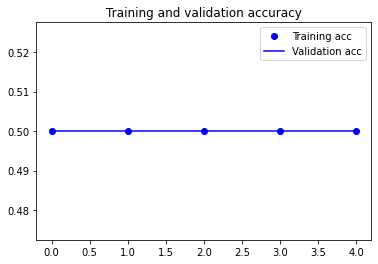

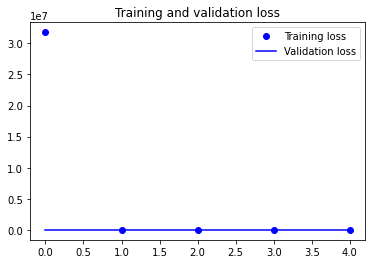

In [17]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 다양한 방법을 사용하여 모델의 성능 올리기
skip connection, pre-trained model 등 다양한 방법을 사용하여 기본적인 VGG16 모델의 성능보다 높은 정확도를 구해보세요.

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
# print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
# print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
# print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
# print(validation_dogs_dir)

num_cats_tr = len(os.listdir(train_cats_dir))
# print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
# print('total training dog images:', num_dogs_tr)

# print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
# print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
# print('total validation dog images:', num_dogs_val)

# print("--")

total_train = num_cats_tr + num_dogs_tr
# print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
# print("Total validation images:", total_val)

In [9]:
# 기존 모델의 배치 사이즈, 에포크의 수, learning rate 수정, 레이어의 출력 사이즈 줄이기 등을 해본다. 
# parameter Initialization
batch_size = 32
epochs = 40
IMG_HEIGHT = 256
IMG_WIDTH = 256

# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)   

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

input_layer = tf.keras.layers.Input(shape=(256, 256, 3))
conv64_1 = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
conv64_2 = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(conv64_1)
batch_nml_1 = tf.keras.layers.BatchNormalization()(conv64_2)
maxpool_1 = tf.keras.layers.MaxPool2D((2, 2))(conv64_2)

conv128_1 = tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(maxpool_1)
conv128_2 = tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(conv128_1)
batch_nml_2 = tf.keras.layers.BatchNormalization()(conv128_2)
maxpool_2 = tf.keras.layers.MaxPool2D((2, 2))(conv128_2)

conv256_1 = tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(maxpool_2)
conv256_2 = tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(conv256_1)
batch_nml_3 = tf.keras.layers.BatchNormalization()(conv256_2)
maxpool_3 = tf.keras.layers.MaxPool2D((2, 2))(conv256_2)

conv512_1 = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(maxpool_3)
conv512_2 = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv512_1)
batch_nml_4 = tf.keras.layers.BatchNormalization()(conv512_2)
maxpool_4 = tf.keras.layers.MaxPool2D((2, 2))(conv512_2)

conv512_4 = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(maxpool_4)
conv512_5 = tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv512_4)
batch_nml_5 = tf.keras.layers.BatchNormalization()(conv512_5)
maxpool_5 = tf.keras.layers.MaxPool2D((2, 2))(conv512_5)

flatten_layer = tf.keras.layers.Flatten()(maxpool_5)
fc_1 = tf.keras.layers.Dense(512, activation='relu')(flatten_layer)
fc_2 = tf.keras.layers.Dense(128, activation='relu')(fc_1)
fc_3 = tf.keras.layers.Dense(32, activation='relu')(fc_2)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(fc_3)

model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
# model.summary()

loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.0001)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/40
62/62 [==============================] - 36s 562ms/step - loss: 0.6937 - binary_accuracy: 0.4915 - val_loss: 0.6927 - val_binary_accuracy: 0.5000
Epoch 2/40
62/62 [==============================] - 35s 552ms/step - loss: 0.6933 - binary_accuracy: 0.4975 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 3/40
62/62 [==============================] - 35s 549ms/step - loss: 0.6932 - binary_accuracy: 0.4780 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 4/40
62/62 [==============================] - 34s 545ms/step - loss: 0.6932 - binary_accuracy: 0.4975 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 5/40
62/62 [==============================] - 34s 545ms/step - loss: 0.6934 - binary_accuracy: 0.5050 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 6/40
62/62 [==============================] - 35s 546ms/step - loss: 0.6934 - binary_accuracy: 0.5030 - val_loss: 0.6933 - va

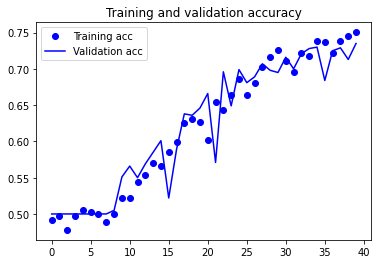

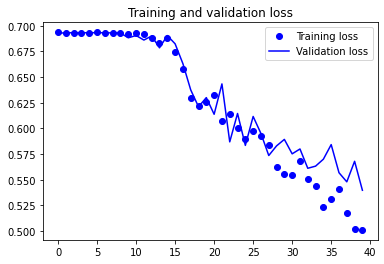

In [10]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

회고 : 
- 에포크 수, 이미지 사이즈 등을 조정했을 때 val_accuracy에 크게 변동이 없었으나, 모델의 레이어 구조를 간단화하고, 레이어의 출력 크기를 줄이고 나서 정확도가 증가하는 것을 볼 수 있었다. 
- 중간에 val_loss가 이상하게 폭증하는 현상을 확인하고, learning rate를 0.0001로 줄여서 이상치에 예민한 현상을 줄일 수 있었다. 
- 에포크 40으로 설정했을 때, 전제적인 정확도 아직 요동치는 것을 확인 할 수 있었으나, 아직 과소적합인 것으로 추정하여 나중에 에포크 수를 100으로 늘려 다시 테스트할 필요가 있어 보인다. 
- 일단 현재 에포크 40의 기준으로, 정확도 73.5%인 모델로 학습된 것으로 마무리 하겠다. 